# WASP-80b: GP Hyperparameter estimation 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
from exotk.utils.misc import fold
from extcore import *

%run extcore.py

lpf = LPFFukui2014(use_ldtk=False)
lpfo = LPFTM(use_ldtk=False, constant_k=True, noise='white')
pv0 = pd.read_hdf(result_file,'ckwn_ldtk/fc').median().values

In [27]:
pv1 = zeros(lpf.ps.ndim)
pv1[:5] = pv0[:5]

if lpf.use_ldtk:
    u,v = lpf.lp.coeffs_qd()[0].T
    q1,q2 = map_uv_to_qq(u,v)
    pv1[lpf._sq1:lpf._sq1+2*lpf.npb:2] = q1
    pv1[lpf._sq2:lpf._sq2+2*lpf.npb:2] = q2
else:
    pv1[lpf._sq1:lpf._sq1+2*lpf.npb:2] = pv0[lpfo._sq1:lpfo._sq1+2*lpf.npb:2]
    pv1[lpf._sq2:lpf._sq2+2*lpf.npb:2] = pv0[lpfo._sq2:lpfo._sq2+2*lpf.npb:2]
pv1[lpf._sbl:lpf._sbl+lpf.nlc] = 1

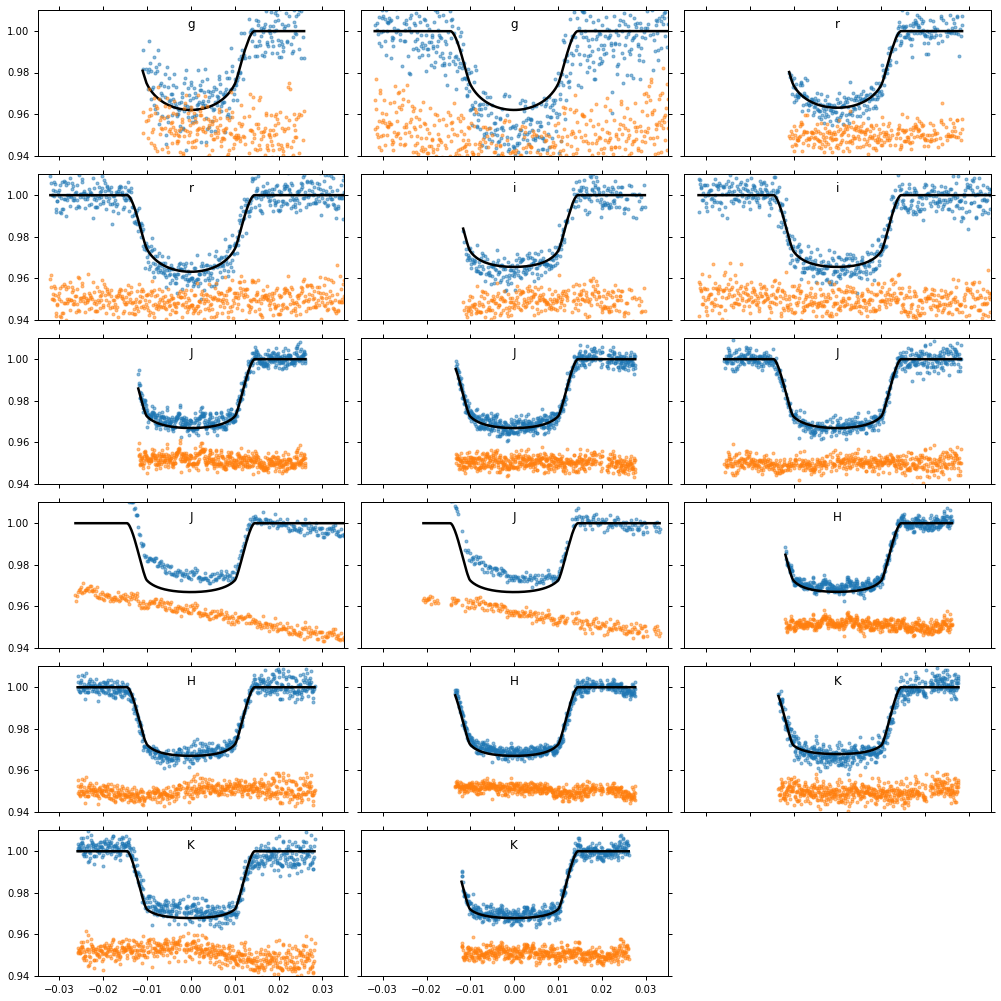

In [28]:
phases = map(lambda t: fold(t, P, TC, 0.5)-0.5, lpf.times)
fluxes_m = lpf.compute_lc_model(pv1)
fig,axs = subplots(6,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]+0.95,'.', alpha=0.5)
    a.text(0.5, 0.95, lpf.passbands.iloc[ilc], ha='center', va='top', size=12, transform=a.transAxes)
setp(axs, ylim=(0.94,1.01), xlim=(-0.035,0.035))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [29]:
fluxes_m = lpf.compute_transit(pv0)
residuals = [fo-fm for fo,fm in zip(lpf.fluxes,fluxes_m)]

In [34]:
fluxes_m = lpf.compute_transit(pv0)
residuals = [fo-fm for fo,fm in zip(lpf.fluxes,fluxes_m)]
gps = [GPF14(gpin, res) for gpin,res in zip(lpf.gp_inputs,residuals)]
hps = []

In [42]:
hps = []
for i,gp in enumerate(gps):
    de = DiffEvol(gp.lnposterior, gp.ps.bounds, 50, maximize=True)
    de.optimize(50)
    hps.append(gp.fit(de.minimum_location, False))
    clear_output(wait=True)
    display(HTML('{:d} / {:d}'.format(i+1, len(gps))))

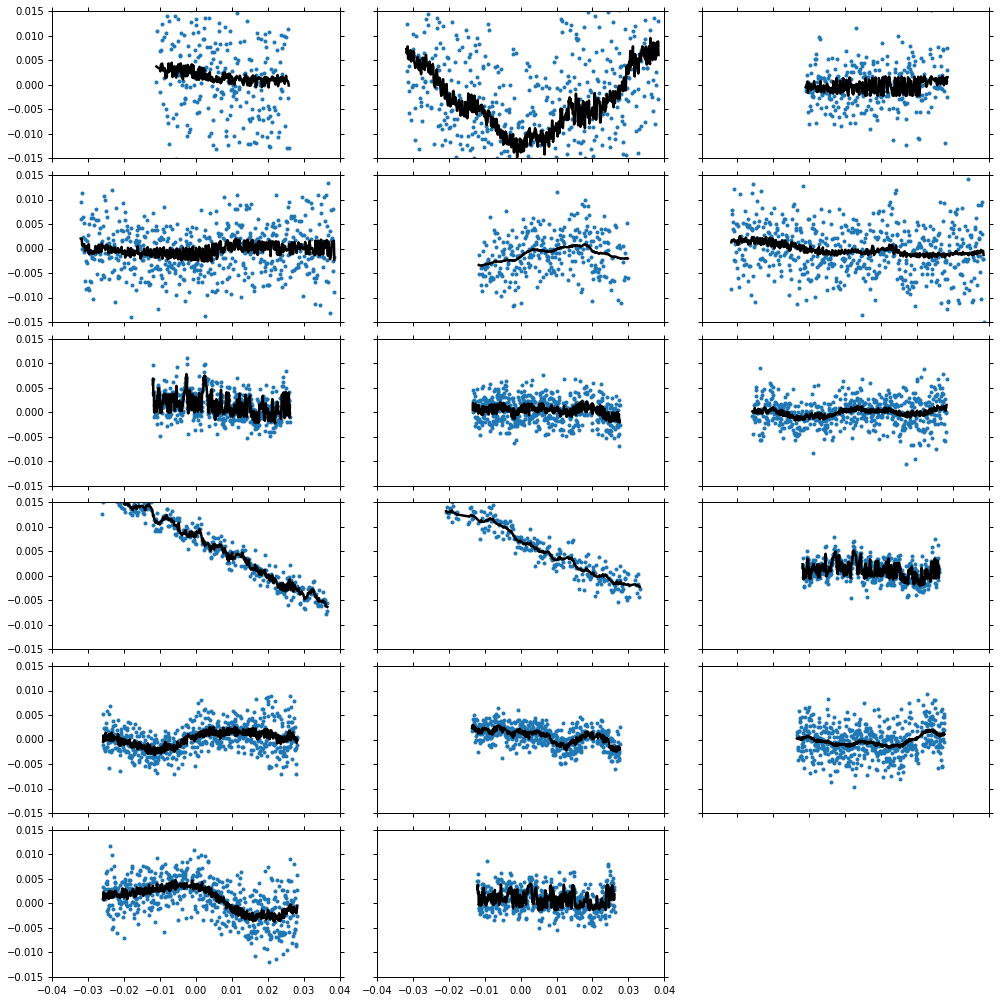

In [46]:
fig,axs = subplots(6,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    axs.flat[iax].plot(phases[ilc],gps[ilc].flux,'.', alpha=1)
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict(None)
    axs.flat[iax].plot(phases[ilc], pr, 'k')
setp(axs, ylim=(-0.015,.015), xlim=(-0.04,0.04))
fig.tight_layout()
axs.flat[-1].set_visible(False)

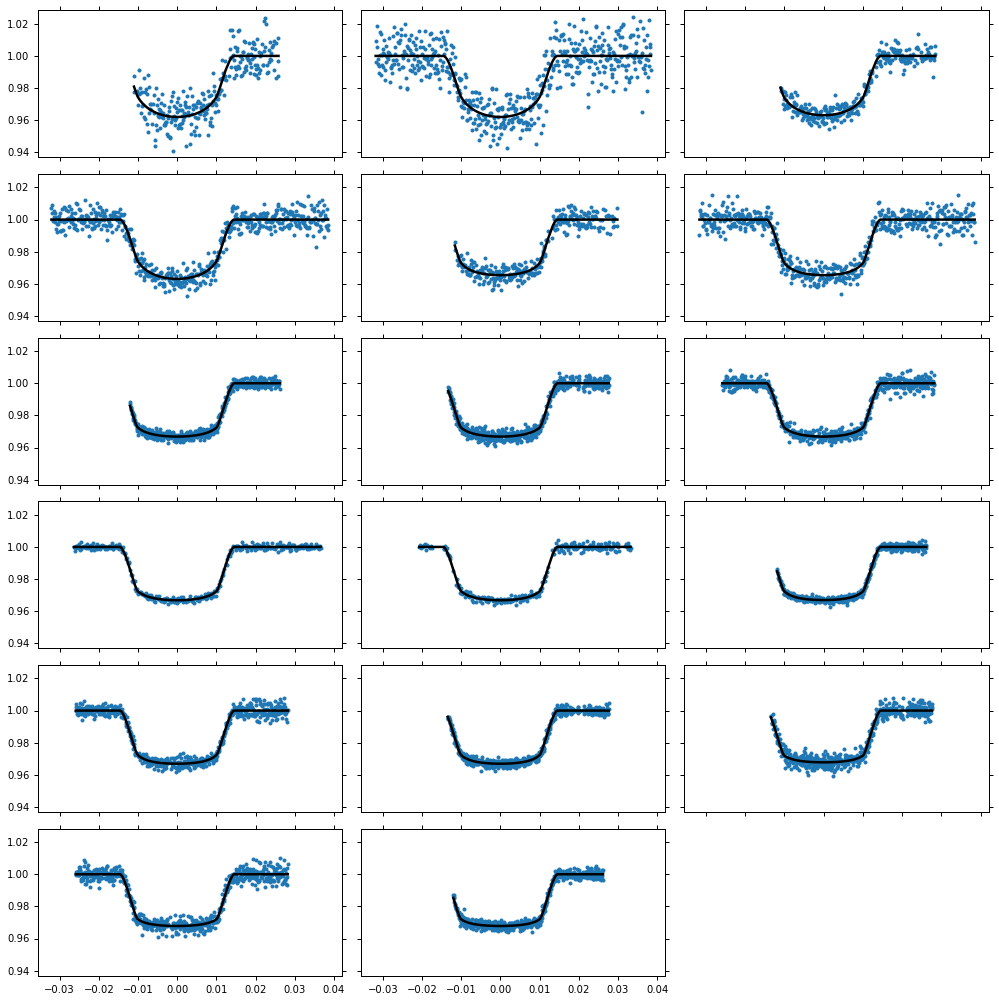

In [53]:
fig,axs = subplots(6,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict(None)
    axs.flat[iax].plot(phases[ilc],lpf.fluxes[ilc]-pr,'.', alpha=1)
    axs.flat[iax].plot(phases[ilc],fluxes_m[ilc],'k')
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [50]:
f = pd.HDFStore('data/external_lcs.h5')
lcnames = [k[4:] for k in f.keys() if 'lc/fukui' in k]
f.close()

df = pd.DataFrame(hps, columns=gp.names, index=lpf.passbands)
df['lc_name'] = lcnames

df

,log10_time_amplitude,inverse_time_scale,log10_xy_amplitude,inverse_x_scale,inverse_y_scale,log10_airmass_amplitude,inverse_airmass_scale,white_noise,lc_name
passband,,,,,,,,,
H,-2.487400,7.515075,-2.911187,1.000994,1.000481,-3.499999,16.100481,-2.877025,fukui2014/H/irsf_130716
H,-2.454089,19.999369,-3.246325,1.000000,1.799790,-3.500000,32.180375,-2.801563,fukui2014/H/irsf_130822
H,-2.572243,19.930594,-3.072707,1.000398,1.002186,-2.993743,49.999546,-2.598322,fukui2014/H/irsf_131007
J,-3.499982,14.600344,-2.756579,1.000000,1.000047,-2.834685,3.249079,-2.733111,fukui2014/J/irsf_130716
J,-2.552245,19.999744,-3.038065,1.000000,1.824391,-3.500000,6.584070,-2.631224,fukui2014/J/irsf_130822
J,-2.708619,20.000000,-3.252443,6.198440,25.218777,-3.267110,28.723063,-2.583549,fukui2014/J/irsf_131007
J,-2.068341,5.000000,-3.223214,17.576376,3.257428,-2.152430,2.285843,-2.872675,fukui2014/J/isle_130813
J,-2.195936,5.000047,-3.500000,48.708324,50.000000,-2.443574,7.464544,-2.788108,fukui2014/J/isle_130922
K,-3.068680,7.707451,-2.900968,1.003024,1.000000,-3.499998,42.696527,-2.725078,fukui2014/K/irsf_130716


In [55]:
df.to_hdf(result_file, 'gphp/fukui2014')